In [1]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
import arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
start = datetime(2015, 1, 1)
end = datetime(2020, 6, 10)

In [3]:
ticker = '^NSEI'

In [4]:
nifty = yf.download(ticker,start,end)
df = pd.DataFrame(nifty)

[*********************100%%**********************]  1 of 1 completed


In [5]:
df.drop(columns = ['Open','High','Low','Close','Volume'],inplace = True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1329 entries, 2015-01-02 to 2020-06-09
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1329 non-null   float64
dtypes: float64(1)
memory usage: 20.8 KB


In [7]:
returns = 100*(df['Adj Close'].pct_change())

In [8]:
df['returns'] = returns

In [9]:
df.dropna(inplace = True)

In [10]:
returns[0] = 0

<Axes: xlabel='Date'>

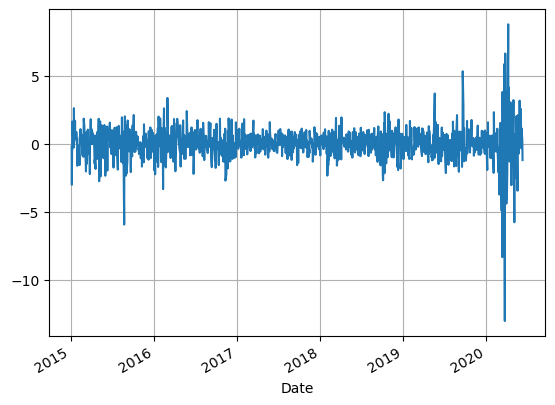

In [11]:
df['returns'].plot(grid = True)

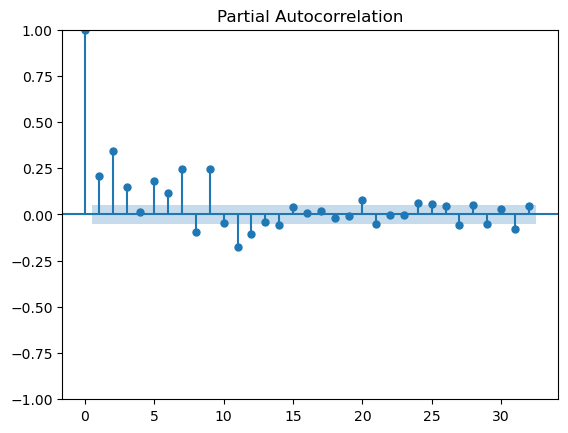

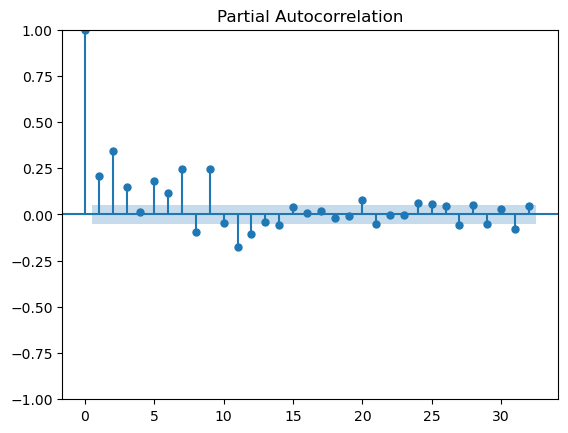

In [12]:
plot_pacf(df['returns']**2)

In [13]:
garch_model = arch.arch_model(df['returns'], vol='GARCH', p=1, q=1)

In [14]:
aic_model = garch_model.fit(disp='off')
bic_model = garch_model.fit(disp='off', options={'ic': 'bic'})

# Compare criteria values
if aic_model.aic < bic_model.bic:
    best_model = aic_model
else:
    best_model = bic_model

print(best_model.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1733.95
Distribution:                  Normal   AIC:                           3475.91
Method:            Maximum Likelihood   BIC:                           3496.67
                                        No. Observations:                 1328
Date:                Thu, Oct 10 2024   Df Residuals:                     1327
Time:                        12:09:44   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0693  2.294e-02      3.020  2.524e-03 [2.432e-0

In [15]:
model = arch_model(returns, p=1, q=1)
model_fit = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 41009600067.58069
Iteration:      2,   Func. Count:     15,   Neg. LLF: 749255269.3009928
Iteration:      3,   Func. Count:     22,   Neg. LLF: 2442.3634463332264
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1738.7928836103702
Iteration:      5,   Func. Count:     35,   Neg. LLF: 2893.886391327582
Iteration:      6,   Func. Count:     42,   Neg. LLF: 1737.4678328612997
Iteration:      7,   Func. Count:     48,   Neg. LLF: 1735.5335207953112
Iteration:      8,   Func. Count:     53,   Neg. LLF: 1735.5334569917586
Iteration:      9,   Func. Count:     57,   Neg. LLF: 1735.533456990957
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1735.5334569917586
            Iterations: 9
            Function evaluations: 57
            Gradient evaluations: 9


In [16]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1735.53
Distribution:                  Normal   AIC:                           3479.07
Method:            Maximum Likelihood   BIC:                           3499.84
                                        No. Observations:                 1329
Date:                Thu, Oct 10 2024   Df Residuals:                     1328
Time:                        12:09:44   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0690  2.292e-02      3.012  2.599e-03 [2.410e-02,  0.114]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0265  9.251e-03      2.861  4.229e-03 [8.331e-03,4.459e-02]
alpha[1]       0.1156  2.730e-02      4.235  2.290e-05   [6.210e-02,  0.169]
beta[1]        0.8610  2.466e-02     34.912 4.865e-267     [  0.813,  0.909]
============================================================================

Covariance estimator: robust
"""

In [17]:
rolling_predictions = []
test_size = 243

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [18]:
end_range = datetime(2020, 6, 10)
start_range = end_range - pd.Timedelta(days = 365)

In [19]:
df1 = pd.DataFrame()

In [20]:
df1['returns'] = df['returns'].loc[start_range:end_range]
df1['predictions'] = rolling_predictions

<Axes: xlabel='Date'>

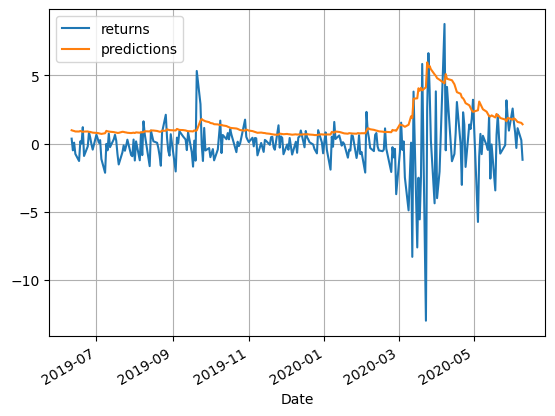

In [21]:
df1[['returns','predictions']].plot(grid = True)